# LAXPC Tutorial Notebook

# import python modules

In [1]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy as sc

# Reading event file, gti file,response file

We need following files for this tutorial: 
1) A LAXPC events file without bary correction.
2) An event file with bary correction.
3) A gti file (which contains the good time start and stop time values).
4) A response file.
The files can be open in the same format as described in the example below.

In [3]:
fevents=fits.open("/app/notebooks/Final_winterschool_xray_tutorial_material/ObsID406_02741_event.fits")
fevents_bary=fits.open("/app/notebooks/Final_winterschool_xray_tutorial_material/ObsID406_02741_laxpc_bary.fits")
fgti=fits.open('/app/notebooks/Final_winterschool_xray_tutorial_material/ObsID406_02741_laxpc1_bary.gti')
fresponse=fits.open('/app/notebooks/Final_winterschool_xray_tutorial_material/lx10_17aug16.rmf')

# Some information about fits file

From the files we can obtain informations like the length, header etc.

In [4]:
#len(fevent_bary)
#fevent_bary[1].header

# Change in time after bary correction

Observe the time difference between the data from the event file and bary correction file.

In [5]:
time=fevents[1].data['TIME']
time_bary=fevents_bary[1].data['TIME']
time_diff=time[0]- time_bary[0]
time_diff

73.24125623703003

# Lightcurve without GTI

Plot the light curve without applying gti cuts. This plot will consist of both gti(good time interval) data as well as bti (bad time interval) data. We can compare the two light curves obtained before and after applying gti cuts.

Text(0, 0.5, '$counts\\ s^{-1}$')

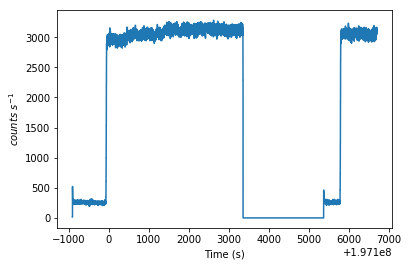

In [6]:
# Define timebins
binsize = 1
tbins = np.arange(time_bary.min(), time_bary.max(), binsize)

# Make histogoram
counts_time, t_bins = np.histogram(time_bary, bins=tbins)
t_bins = (t_bins[1:] + t_bins[:-1])/2

# Plot
plt.plot(t_bins, counts_time/binsize, ls='steps-mid')
plt.xlabel('Time (s)')
plt.ylabel('$counts\ s^{-1}$')

# applying GTI

Read and filter event file to keep in array only events within the good time interval.

In [7]:
gtidata=fgti[1].data
t_start=gtidata[0][0],gtidata[1][0]
t_stop=gtidata[0][1],gtidata[1][1]
t_start, t_stop

((197099975.0, 197105810.0), (197103300.0, 197106645.0))

Here we compare the lenght of the event file and the gti file.

In [8]:
eventsdata=fevents_bary[1].data
for i in range(len(t_start)) :
    time_gti = time_bary[np.where((time_bary>=t_start[i]) & (time_bary<=t_stop[i]))]
len(time_bary), len(time_gti)

(13614384, 2550273)

#  lightcurve after applying GTI

Here we plot the light curve only taking time values falling in the gti range. We can compare this plot with the plot before applying gti cuts.

Text(0, 0.5, '$counts\\ s^{-1}$')

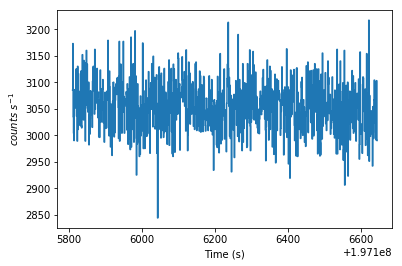

In [9]:
# Define timebins
binsize = 1
tbins = np.arange(time_gti.min(), time_gti.max(), binsize)

# Make histogoram
counts_time, t_bins = np.histogram(time_gti, bins=tbins)
t_bins = (t_bins[1:] + t_bins[:-1])/2

# Plot
plt.plot(t_bins, counts_time/binsize, ls='steps-mid')
plt.xlabel('Time (s)')
plt.ylabel('$counts\ s^{-1}$')

# Calculating Phase and folding

1) From filtered events calculate the phase array using the expression and constants provided.
2) Create the histogram of array.
3) Obtain the pulse profile.
We can see that the pulse profile matches with that of Crab Nebula.

Text(0, 0.5, 'norm ')

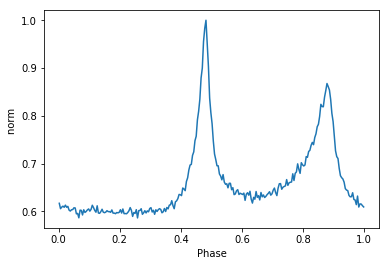

In [10]:
tref=fevents_bary[1].header['MJDREFI']
tref=tref*86400
time_current =time_gti + tref
T0=57480.5635028439*86400 # Reference Epoch for which nu is known
t_phase=time_current-T0

# freq and its derivatives
nu,nudot,nuddot = 29.6553306828504,-3.69261197216621e-10,-3.9353064617231e-20

#calculating phase
phi=t_phase*(nu+0.5*t_phase*(nudot+t_phase*nuddot/3.0))
phi_int=np.zeros(len(phi))
for i in range(len(phi)):
    phi_int[i]= int(phi[i])
phase=phi - phi_int
phase=phase+1
min(phase),max(phase)

#folding phase
no_bins=250
pbins=np.linspace(0.,1.,no_bins+1)
phase_counts, pbin_edges = np.histogram(phase,bins=pbins)
pbin_edges = (pbin_edges[1:] + pbin_edges[:-1])/2
phase_counts=[float(i) for i in phase_counts]
phase_counts=np.array(phase_counts)
pcounts=phase_counts/max(phase_counts) # normalising 
plt.plot(pbin_edges, pcounts) # plotting pulse profile
plt.xlabel('Phase')
plt.ylabel('norm ')

# Making energy spectrum

1) Bin in energy (You can play around with binsize).
2) Show apparent spectrum in log scale.
3) Plot log Nvs log E.

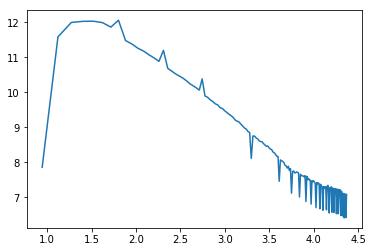

In [11]:
for i in range(len(t_start)) :
    energy_gti = eventsdata['Energy'][np.where((time_bary>=t_start[i]) & (time_bary<=t_stop[i]) & (eventsdata['Energy']<=80))]

#energy_gti, len(energy_gti)
binsize = 0.5 #change as required
ebins = np.arange(energy_gti.min(), energy_gti.max(), binsize)
counts_energy, ebin_edges =np.histogram(energy_gti,bins=ebins)
ebin_edges = (ebin_edges[1:] + ebin_edges[:-1])/2
log_counts=np.log(counts_energy)
log_ebins=np.log(ebin_edges)
plt.plot(log_ebins, log_counts)

# Making PHA spectrum

1) Bin in channel.
2) Show apparent spectrum in log scale.
3) Plot log N vs log 'channel'

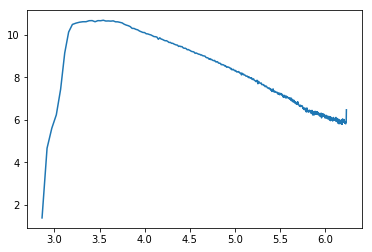

In [12]:
for i in range(len(t_start)) :
    channel_gti = eventsdata['Channel'][np.where((time_bary>=t_start[i]) & (time_bary<=t_stop[i]) & (eventsdata['Channel']<=512) )]

binsize = 1 # change as required
cbins = np.arange(channel_gti.min(), channel_gti.max(), binsize)
counts_channel, cbin_edges =np.histogram(channel_gti,bins=cbins)
cbin_edges = (cbin_edges[1:] + cbin_edges[:-1])/2
log_counts_channel=np.log(counts_channel)
log_cbins=np.log(cbin_edges)
plt.plot(log_cbins,log_counts_channel)


# Making contour plots for response matrix

1) Read in response file.
2) Make 2D plot/ contour for the MATRIX.

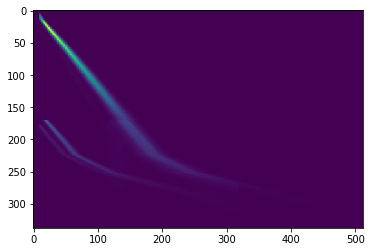

In [13]:
resp_data = fresponse[2].data
mat = np.zeros((len(resp_data), len(resp_data[0]['matrix'])))
for i in range(338): mat[i,:] = resp_data[i]['matrix']

# plotting contour and 2d-array of response matrix 
plt.imshow(mat)

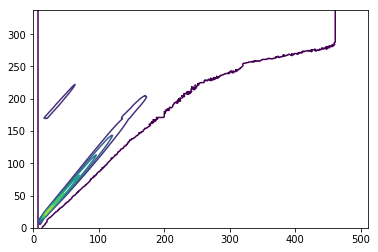

In [14]:
plt.contour(mat)